In [1]:
from bs4 import BeautifulSoup
import requests
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.reset_orig()
# from collections import defaultdict

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 12

## Scraping info from one listing

In [3]:
ex_page = "https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1"

In [4]:
ex_page = "https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-St-Pauli.5796749.html"

In [194]:
ex_page = "https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html?mf=1"

In [195]:
r = requests.get(ex_page)

In [196]:
soup = BeautifulSoup(r.text, "lxml")

In [197]:
panel_bodies = soup.find_all("div", "panel-body")

In [200]:
with open("debug.html", "w") as f:
    f.write(str(soup))

In [198]:
panel_info = panel_bodies[0]

IndexError: list index out of range

In [10]:
def get_price_dict(panel):
    raw_prices = panel.find('div', 'col-xs-12 col-sm-5')
    price_list = [x.text.lower().strip().strip(":€").replace(" ", "_")
                  for x in raw_prices.find_all('td') 
                  if not x.text.upper().strip().startswith('SCHUFA')]
    price_dict = {}
    for name, price in zip(price_list[:-1:2], price_list[1::2]):
        price_dict[name] = price
    return price_dict

In [11]:
get_price_dict(panel_info)

{'base_rent': '420',
 'deposit': '840',
 'miscellaneous_costs': '30',
 'utilities': 'n.a.'}

In [12]:
def get_address_dict(panel):
    raw_address = panel.find('div', 'col-xs-12 col-sm-4').find('a').text
    address_parts = [x.strip() for x in  raw_address.split('\n') if x.strip() != '']
    house_line =  re.sub(r'  +', ' ', address_parts[0])
    house_parts = house_line.split()
    house_number = -1
    for hp in house_parts:
        if hp.isdigit():
            house_number = hp
            house_line = house_line.replace(house_number, "").strip()
            break
    street = house_line

    postcode_line = re.sub(r'  +', ' ', address_parts[1])
    postcode_line = re.sub(r'Germany', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'Hamburg', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'[\n ]+', ' ', postcode_line)
    postcode_pattern = re.compile(r'(?P<postcode>2[\d]+) (?P<region>.*)', flags=re.I | re.UNICODE)
    postcode_match = postcode_pattern.search(postcode_line)
    postcode = postcode_match['postcode']
    region = postcode_match['region']    
    return {'street': street, 'house_number': int(house_number), 'region': postcode_match['region'], 'postcode': int(postcode_match['postcode'])}

In [13]:
get_address_dict(panel_info)

{'house_number': 254,
 'postcode': 22769,
 'region': 'Eimsbüttel',
 'street': 'Kieler Straße'}

In [14]:
def get_availability_dict(panel):
    availability = panel.find('div', 'col-xs-12 col-sm-3')
    availability_values = [x.text.strip() for x in availability.find_all('b')]
    return dict(zip(['start_date', 'ad_placed'], availability_values))

In [15]:
get_availability_dict(panel_info)

{'ad_placed': 'Online: 2 days', 'start_date': '01.05.2017'}

In [16]:
panel_details = panel_bodies[1]

In [17]:
def get_details_dict(panel):
    raw_details = panel.find('div', 'col-sm-6')
    space_pattern = re.compile(r'[\n ]+')
    details_parts = [space_pattern.sub(' ', x.text.strip()) for x in raw_details.find_all('li')]

    room_area = 0
    area_pattern = re.compile(r'[0-9]+')
    area_match = area_pattern.match(details_parts[0].split()[0])
    if area_match:
        room_area = float(area_match[0])

    total_area = 0
    size_pattern = re.compile(r'Total size: ([0-9]+)', flags=re.I)
    size_match = size_pattern.search(details_parts[1])
    if size_match:
        total_area = float(size_match[1])

    total_num_persons = 0
    np_pattern = re.compile(r'([0-9]+) person')
    num_persons_match = np_pattern.search(details_parts[2])
    if num_persons_match:
        total_num_persons = int(num_persons_match[1])

    num_females, num_males = 0, 0
    male_female_pattern = re.compile(r'([0-9]+) female[s]? and ([0-9]+) male[s]?',  flags=re.I)
    genders_match = male_female_pattern.search(details_parts[2])
    if genders_match:
        num_females, num_males = int(genders_match[1]), int(genders_match[2])

    num_females, num_males
    
    return {'room_area': room_area, 'total_area': total_area, 
            'num_males_current': num_males, 'num_females_current': num_females, 
            'total_occupancy': total_num_persons}

In [18]:
get_details_dict(panel_details)

{'num_females_current': 1,
 'num_males_current': 0,
 'room_area': 13.0,
 'total_area': 60.0,
 'total_occupancy': 2}

In [19]:
panel_further = panel_bodies[2]

In [20]:
def check_ad_ok(soup):
    return "but this ad has been deactivated" not in soup.text

In [192]:
def extract_ad_info_from_soup(ad_soup):
    panels = ad_soup.find_all("div", "panel-body")
    try:
        info_panel = panels[0]

        ad_dict = {'title': ad_soup.title.text}
        ad_dict.update(get_price_dict(info_panel))
        ad_dict.update(get_address_dict(info_panel))

        details_panel = panels[1]
        ad_dict.update(get_details_dict(details_panel))
    except IndexError:
        print("Cannot parse page")
        with open("debug.html", "w") as f:
            f.write(ad_soup.get_text())
        return None
    
    return ad_dict

In [161]:
extract_ad_info_from_soup(soup)

{'base_rent': '420',
 'deposit': '840',
 'house_number': 254,
 'miscellaneous_costs': '30',
 'num_females_current': 1,
 'num_males_current': 0,
 'postcode': 22769,
 'region': 'Eimsbüttel',
 'room_area': 13.0,
 'street': 'Kieler Straße',
 'title': 'Mitbewohner für WG-Gründung in schöner 2 1/2 Zimmer-Wohnung gesucht - Wohngemeinschaften Hamburg-Eimsbüttel',
 'total_area': 60.0,
 'total_occupancy': 2,
 'utilities': 'n.a.'}

In [165]:
def extract_ad_info(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    if not check_ad_ok(soup):
        return None
    else:
        ad_dict = extract_ad_info_from_soup(soup)
#         ad_dict['url'] = url
        return ad_dict

In [24]:
extract_ad_info('https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-St-Pauli.5796749.html')

{'base_rent': 'n.a.',
 'house_number': -1,
 'miscellaneous_costs': 'n.a.',
 'num_females_current': 0,
 'num_males_current': 0,
 'postcode': 20357,
 'region': 'St Pauli',
 'room_area': 0,
 'street': 'Sternstrasse',
 'title': 'Schanze!! 1 Zimmer in der Schanze abzugeben. Top Lage.!! - WGs in Hamburg-St Pauli',
 'total_area': 60.0,
 'total_occupancy': 3,
 'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-St-Pauli.5796749.html',
 'utilities': 'n.a.'}

In [79]:
extract_ad_info('https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Neustadt.4291169.html')

{'base_rent': '430',
 'deposit': '495',
 'house_number': 42,
 'miscellaneous_costs': '85',
 'num_females_current': 0,
 'num_males_current': 2,
 'postcode': 20355,
 'region': 'Neustadt',
 'room_area': 17.0,
 'street': 'Wextrasse',
 'title': 'Grosses Möbliertes Zimmer direkt am Großneumarkt/Neustadt - WG in Hamburg möbliert Hamburg-Neustadt',
 'total_area': 86.0,
 'total_occupancy': 3,
 'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Neustadt.4291169.html',
 'utilities': 'n.a.'}

In [193]:
extract_ad_info('http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1')

Cannot parse page


In [72]:
get_listing_dict(listings[0])

{'date_advertised': '25.04.17',
 'distance': '9,7 km',
 'room_area': '12m²',
 'start_date': '01.05.17',
 'total_rent': '400€',
 'url': 'wg-zimmer-in-Hamburg-Alsterdorf.5260672.html'}

In [25]:
import time
import random

In [26]:
def scrape_urls(url_list):
    print('Getting info on %d ads...' % len(url_list))
    dict_list = []
    for url in url_list:
        print(url)
        time.sleep(random.random()*5 + 1)
        info = extract_ad_info(url)
        if info:
            dict_list.append(info)
    return dict_list

In [189]:
urls = [
    'http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eppendorf.6066386.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.5986295.html?mf=1'
]

urls = [
    'http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eppendorf.6066386.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.5986295.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Nord.5672745.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Stellingen.6079042.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6074471.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Harvestehude.5963393.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Nord.6064793.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.4979594.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.5248077.html?mf=1',
#     'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Bahrenfeld.6061487.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.6059676.html?mf=1',
    'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html?mf=1'
]

In [190]:
dicts = scrape_urls(urls)

Getting info on 16 ads...
http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1
Cannot parse page
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1


KeyboardInterrupt: 

In [29]:
dicts

[{'base_rent': '450',
  'deposit': '500',
  'house_number': 21,
  'miscellaneous_costs': 'n.a.',
  'num_females_current': 0,
  'num_males_current': 2,
  'postcode': 20144,
  'region': 'Eimsbüttel',
  'room_area': 16.0,
  'street': 'Kielortallee',
  'title': '16 qm Zimmer in bester Lage  - Flatshare in Hamburg-Eimsbüttel',
  'total_area': 78.0,
  'total_occupancy': 3,
  'url': 'http://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html?mf=1',
  'utilities': '50'},
 {'base_rent': '410',
  'deposit': '1300',
  'house_number': -1,
  'miscellaneous_costs': '25',
  'num_females_current': 0,
  'num_males_current': 2,
  'postcode': 20259,
  'region': 'Eimsbüttel',
  'room_area': 12.0,
  'street': 'Osterstraße',
  'title': '12qm Zimmer in 3er WG - Zimmer in Hamburg-Eimsbüttel',
  'total_area': 0,
  'total_occupancy': 3,
  'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html?mf=1',
  'utilities': '80'},
 {'base_rent': '400',
  'deposit': '700',
  'hou

In [30]:
df = pd.DataFrame(dicts)

for col in ['base_rent', 'deposit', 'existing_equipment_fee', 'miscellaneous_costs', 'utilities']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(value=0)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 17 columns):
base_rent                 16 non-null int64
deposit                   16 non-null int64
existing_equipment_fee    16 non-null float64
house_number              16 non-null int64
miscellaneous_costs       16 non-null float64
num_females_current       16 non-null int64
num_males_current         16 non-null int64
postcode                  16 non-null int64
region                    16 non-null object
room_area                 16 non-null float64
street                    16 non-null object
title                     16 non-null object
total_area                16 non-null float64
total_occupancy           16 non-null int64
url                       16 non-null object
utilities                 16 non-null float64
total_rent                16 non-null float64
dtypes: float64(6), int64(7), object(4)
memory usage: 2.2+ KB


In [33]:
df.head()

,base_rent,deposit,existing_equipment_fee,house_number,miscellaneous_costs,num_females_current,num_males_current,postcode,region,room_area,street,title,total_area,total_occupancy,url,utilities,total_rent
0,450,500,0.0,21,0.0,0,2,20144,Eimsbüttel,16.0,Kielortallee,16 qm Zimmer in bester Lage - Flatshare in Ha...,78.0,3,http://www.wg-gesucht.de/en/wg-zimmer-in-Hambu...,50.0,500.0
1,410,1300,0.0,-1,25.0,0,2,20259,Eimsbüttel,12.0,Osterstraße,12qm Zimmer in 3er WG - Zimmer in Hamburg-Eims...,0.0,3,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,80.0,515.0
2,400,700,0.0,-1,0.0,1,0,22761,Bahrenfeld,13.0,Ruhrstraße,"13qm Zimmer in schöner, heller Erdgeschosswohn...",0.0,2,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0,400.0
3,490,1000,150.0,9,10.0,0,2,20251,Eppendorf,14.0,Itzehoer Weg,"++++ Hoheluft, zentrumsnah, 14 qm Zimmer ++++ ...",70.0,3,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0,500.0
4,420,840,0.0,254,30.0,1,0,22769,Eimsbüttel,13.0,Kieler Straße,Mitbewohner für WG-Gründung in schöner 2 1/2 Z...,60.0,2,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0,450.0


## Scraping to get lots of listings

In [40]:
list_page = "https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_only=1"

In [41]:
rall = requests.get(list_page)

In [43]:
soup_all = BeautifulSoup(rall.text, 'lxml')

In [51]:
listings = soup_all.find_all('tr', class_=re.compile(r'listenansicht[01]'))

In [52]:
len(listings)

20

In [91]:
def get_listing_dict(listing):
    listing_info = [s.text.strip() for s in listing.find_all('span') if s.text.strip()]
    listing_cols = ['date_advertised', 'total_rent', 'room_area', 'distance', 'start_date']
    listing_dict = dict(zip(listing_cols, listing_info))
    listing_dict['url'] = "https://www.wg-gesucht.de/en/" + listing.find('a', class_=re.compile('listenansicht[01]'), href=re.compile('wg-.*'))['href']
    listing_dict['room_area'] = int(re.match(r'[0-9]+', listing_dict['room_area'])[0])
    listing_dict['total_rent'] = int(listing_dict['total_rent'].strip('€'))
    listing_dict['distance'] = float(listing_dict['distance'].strip(" km").replace(",", "."))
    return listing_dict

In [92]:
get_listing_dict(listings[0])

{'date_advertised': '25.04.17',
 'distance': 9.7,
 'room_area': 12,
 'start_date': '01.05.17',
 'total_rent': 400,
 'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html'}

In [93]:
get_listing_dict(listings[1])

{'date_advertised': '25.04.17',
 'distance': 3.6,
 'room_area': 36,
 'start_date': '01.05.17',
 'total_rent': 600,
 'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Ottensen.6060847.html'}

In [127]:
def get_listings_from_list_page(url):
    rall = requests.get(url)
    soup_all = BeautifulSoup(rall.text, 'lxml')
    listings = soup_all.find_all('tr', class_=re.compile(r'listenansicht[01]'))
    listings_dicts = [get_listing_dict(listing) for listing in listings]
    print("Got %d listings" % len(listings_dicts))
    return listings_dicts
    

In [128]:
list_page_start = "https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_only=1"
list_page_template = list_page_start.replace("0.html", "{N}.html")

In [129]:
listings_dicts = []
for i in range(10):
    list_page = list_page_template.replace("{N}", str(i))
    time.sleep(random.random()*5 + 0.5)    
    print("Getting listings from", list_page)
    listings_dicts.extend(get_listings_from_list_page(list_page))

Getting listings from https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_only=1
Got 20 listings
Getting listings from https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg.55.0.0.1.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_only=1
Got 20 listings
Getting listings from https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg.55.0.0.2.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_onl

In [135]:
# listings_dicts2 = [item for l in listings_dicts for item in l]
# listings_dicts = listings_dicts2

In [136]:
listings_dicts

[{'date_advertised': '25.04.17',
  'distance': 7.7,
  'room_area': 17,
  'start_date': '26.04.17',
  'total_rent': 515,
  'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Neustadt.4291169.html'},
 {'date_advertised': '25.04.17',
  'distance': 6.4,
  'room_area': 14,
  'start_date': '01.05.17',
  'total_rent': 500,
  'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Eppendorf.6066386.html'},
 {'date_advertised': '25.04.17',
  'distance': 9.4,
  'room_area': 18,
  'start_date': '29.04.17',
  'total_rent': 650,
  'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-St-Georg.5058705.html'},
 {'date_advertised': '25.04.17',
  'distance': 9.7,
  'room_area': 12,
  'start_date': '01.05.17',
  'total_rent': 400,
  'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html'},
 {'date_advertised': '25.04.17',
  'distance': 3.6,
  'room_area': 36,
  'start_date': '01.05.17',
  'total_rent': 600,
  'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hambu

In [188]:
for i, d in enumerate(listings_dicts[0:5]):
    time.sleep(random.random()*2 + 0.5)
    print(d['url'])
    info = extract_ad_info(d['url'])
    if info:
        d.update(info)
    if i % 20 == 0:
        time.sleep(60)

https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Altstadt.6081751.html
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Neustadt.6076998.html
Cannot parse page
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Nord.5672745.html
Cannot parse page
https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Altona-Altstadt.6056848.html
Cannot parse page


KeyboardInterrupt: 

In [144]:
extract_ad_info("https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Stellingen.6079042.html")

{'base_rent': '300',
 'deposit': '600',
 'existing_equipment_fee': '0',
 'house_number': 50,
 'miscellaneous_costs': '0',
 'num_females_current': 1,
 'num_males_current': 1,
 'postcode': 22525,
 'region': 'Stellingen',
 'room_area': 13.0,
 'street': 'Warnstedtstraße,',
 'title': 'Unmöbliertes 13 qm Zimmer in netter 3er WG in Hamburg-Stellingen - WGs Hamburg-Stellingen',
 'total_area': 70.0,
 'total_occupancy': 3,
 'url': 'https://www.wg-gesucht.de/en/wg-zimmer-in-Hamburg-Stellingen.6079042.html',
 'utilities': '50'}

In [168]:
df = pd.DataFrame(listings_dicts)

for col in ['base_rent', 'deposit', 'existing_equipment_fee', 'miscellaneous_costs', 'utilities']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(value=0)

In [169]:
for col in ['date_advertised', 'start_date']:
    df[col] = pd.to_datetime(df[col], dayfirst=True)

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 20 columns):
base_rent                 200 non-null float64
date_advertised           200 non-null datetime64[ns]
deposit                   200 non-null float64
distance                  200 non-null float64
existing_equipment_fee    200 non-null float64
house_number              40 non-null float64
miscellaneous_costs       200 non-null float64
num_females_current       40 non-null float64
num_males_current         40 non-null float64
postcode                  40 non-null float64
region                    40 non-null object
room_area                 200 non-null float64
start_date                200 non-null datetime64[ns]
street                    40 non-null object
title                     40 non-null object
total_area                40 non-null float64
total_occupancy           40 non-null float64
total_rent                200 non-null int64
url                       200 non-null object
uti

In [171]:
df.head()

,base_rent,date_advertised,deposit,distance,existing_equipment_fee,house_number,miscellaneous_costs,num_females_current,num_males_current,postcode,region,room_area,start_date,street,title,total_area,total_occupancy,total_rent,url,utilities
0,430.0,2017-04-25,495.0,7.7,0.0,42.0,85.0,0.0,2.0,20355.0,Neustadt,17.0,2017-04-26,Wextrasse,Grosses Möbliertes Zimmer direkt am Großneumar...,86.0,3.0,515,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0
1,490.0,2017-04-25,1000.0,6.4,150.0,9.0,10.0,0.0,2.0,20251.0,Eppendorf,14.0,2017-05-01,Itzehoer Weg,"++++ Hoheluft, zentrumsnah, 14 qm Zimmer ++++ ...",70.0,3.0,500,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0
2,650.0,2017-04-25,0.0,9.4,0.0,84.0,0.0,0.0,1.0,20099.0,St Georg,18.0,2017-04-29,Lange Reihe,Hinterhof Lange Reihe: großes Zimmer mit Blick...,50.0,2.0,650,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0
3,370.0,2017-04-25,600.0,9.7,0.0,-1.0,0.0,1.0,1.0,22337.0,Alsterdorf,12.0,2017-05-01,Alsterdorfstrasse,"Gemütliche, entspannte 3er WG - U1/S1 in 5 Min...",0.0,3.0,400,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,30.0
4,600.0,2017-04-25,600.0,3.6,0.0,-1.0,0.0,0.0,1.0,22763.0,Ottensen,36.0,2017-05-01,Griegstrasse,1 Zi. 36m2 in großer Wohnung in Ottensen - WG...,88.0,2.0,600,https://www.wg-gesucht.de/en/wg-zimmer-in-Hamb...,0.0


In [172]:
df.region.unique().tolist()

['Neustadt',
 'Eppendorf',
 'St Georg',
 'Alsterdorf',
 'Ottensen',
 'Altona-Altstadt',
 'Lurup',
 'Rotherbaum',
 'Winterhude',
 'Eimsbüttel',
 'Barmbek-Süd',
 'Bahrenfeld',
 'Altona-Nord',
 'Münzviertel Hammerbrook / St. Georg',
 'St Pauli',
 'Hoheluft-Ost',
 'Lokstedt',
 'Schanze Eimsbüttel',
 'Uhlenhorst',
 nan]

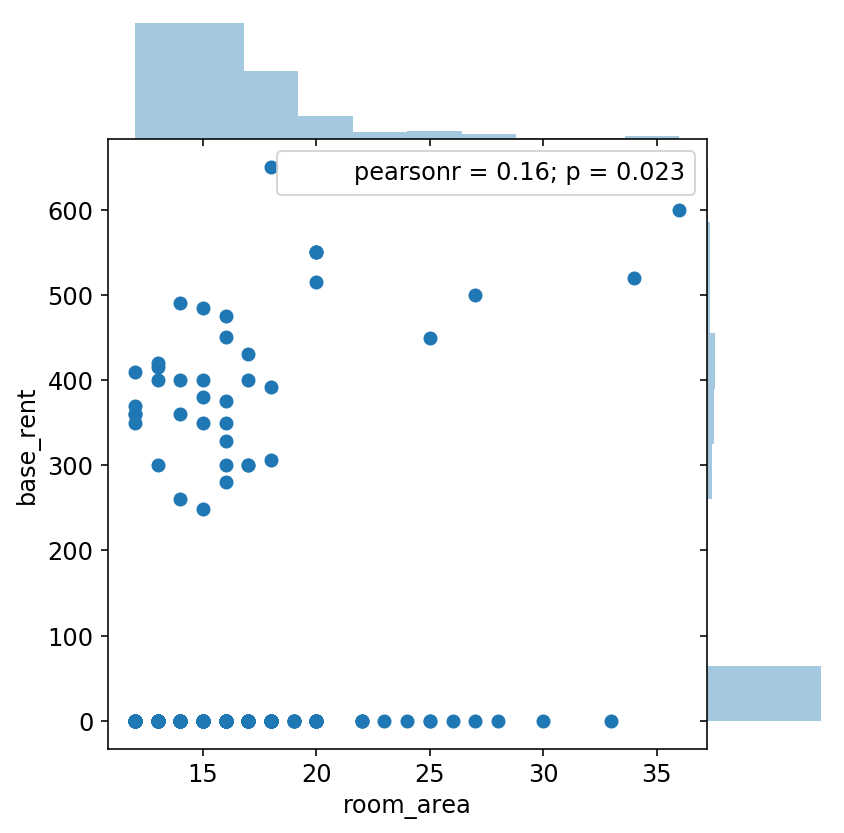

In [173]:
sns.jointplot(x='room_area', y='base_rent', 
              data=df, 
              space=0, marginal_kws={'bins': 10});

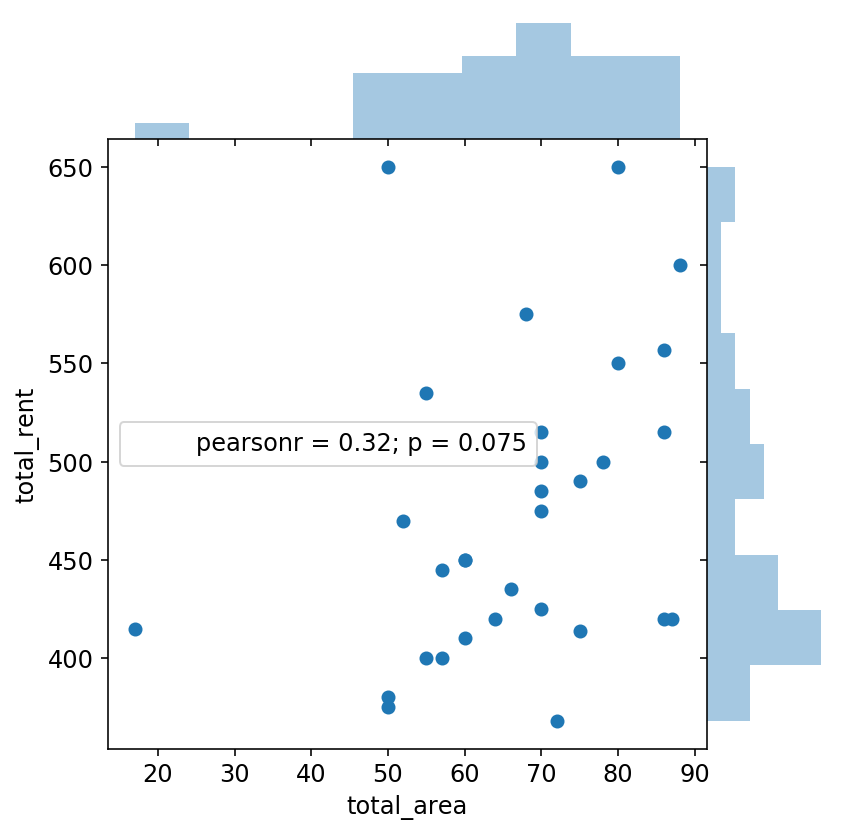

In [174]:
sns.jointplot(x='total_area', y='total_rent', 
              data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

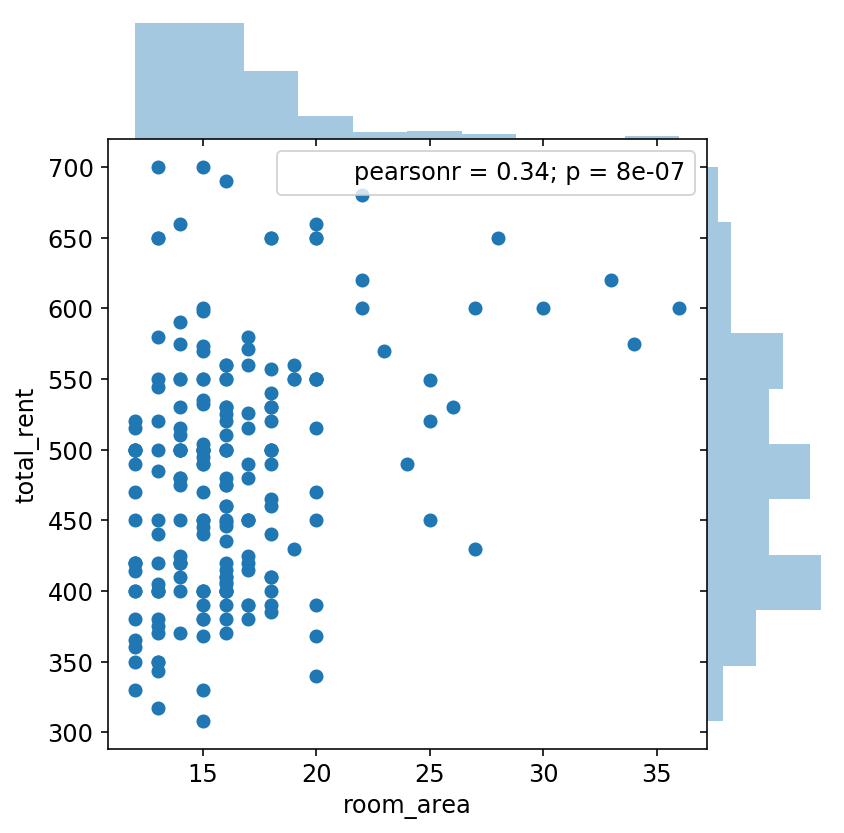

In [175]:
sns.jointplot(x='room_area', y='total_rent', 
              data=df, 
              space=0, marginal_kws={'bins': 10});

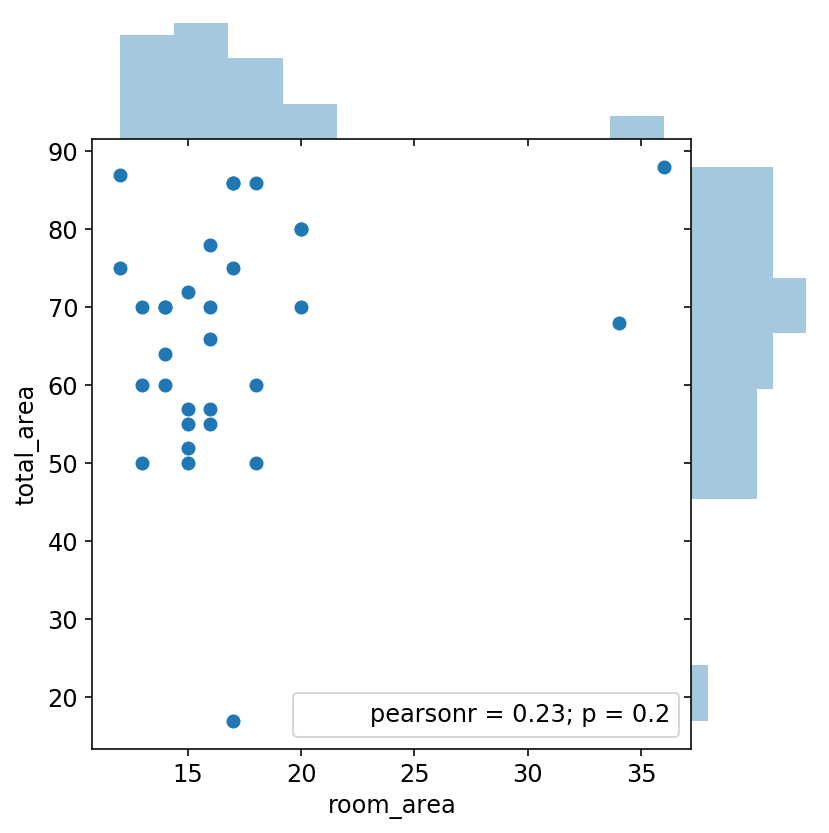

In [176]:
sns.jointplot(x='room_area', y='total_area', 
              data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

/Users/robin/.virtualenvs/ScrapingPy3/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


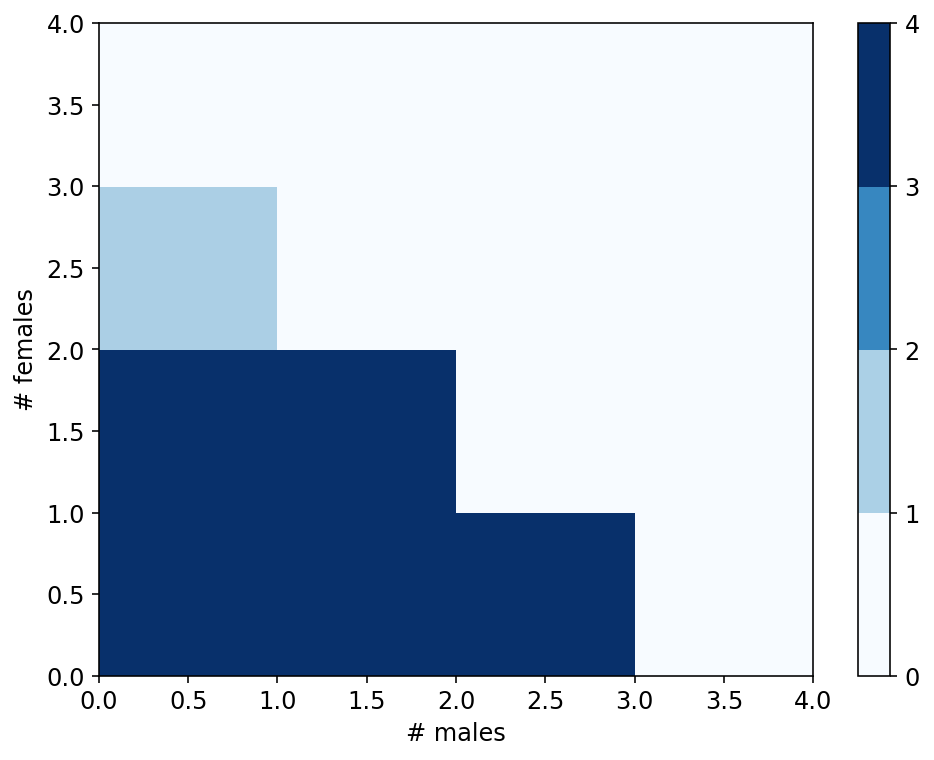

In [177]:
plt.hist2d(df.num_males_current, df.num_females_current,
           bins=[range(5), range(5)],
           norm=colors.BoundaryNorm(boundaries=range(5), ncolors=256), cmap='Blues');
plt.xlabel('# males')
plt.ylabel('# females')
plt.colorbar();

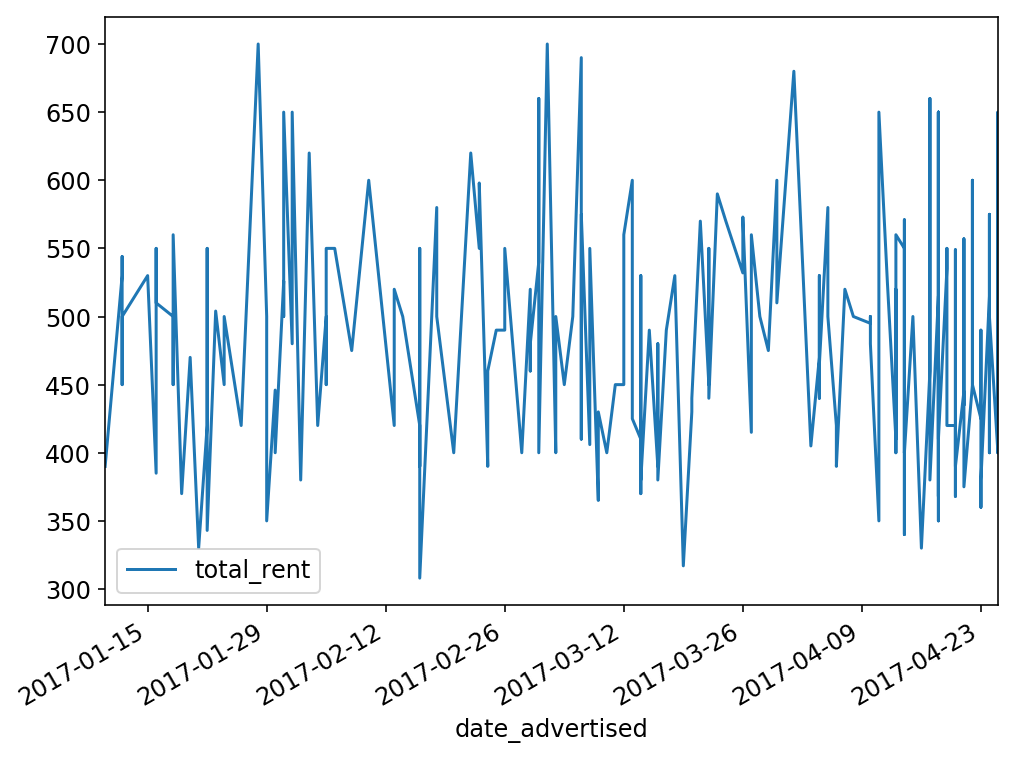

In [184]:
df.plot(x='date_advertised', y='total_rent');